## Plotting ISCO sample inventory over winter 2023 discharge

### Discharge data from Satish in sonya-may2024 directory

## TO DO:

- [ ] the datetime combination in Section 3 is very ugly but functional, make that more efficient

Rows: 138 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): Sample ID, Site, Date, Type, Index-notes, ICP-notes, IC-notes, NR...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time
  Zone"))`.
Caused by warning:
!  3 failed to parse.”
Rows: 77548 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): type, NO3_source, TP_source, TDP_source, PP_source, SRP_source
dbl  (10): q_cms_hb, q_cms_mb, q_cms_pred, q_cms_hb_filled, NO3, year, TP, T...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data

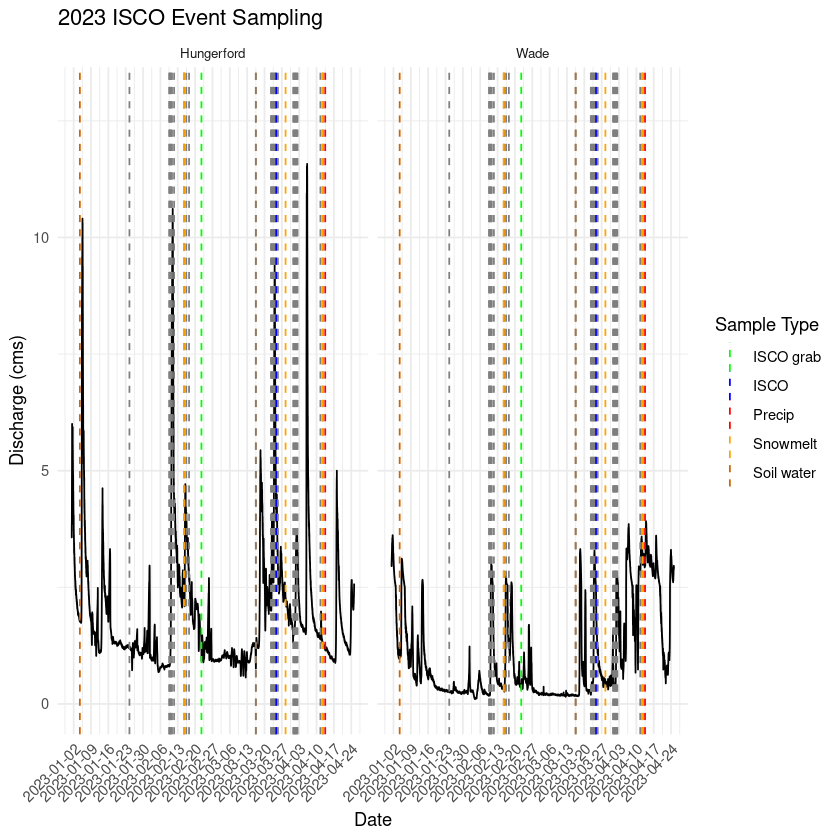

In [84]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
c_input_dir <- "~//OneDrive/git-repos/EMMA/data"
output_dir <- "~//OneDrive/git-repos/EMMA/output/"

##########################
# READ IN AND CLEAN DATA #
##########################

# read in the RI23 data
# see joining here: 
# https://github.com/MeganEDuffy/EMMA/blob/main/isco_metadata/LCBP_RI_sample_index/RI23-sample-ID-join.ipynb
MetadataISCO <- read_csv(file.path(c_input_dir, "/newrnet-chemistry/RI23-IC-ICP-isotope-joined.csv"))

# Convert the "Date" column to date format and Time to time format
MetadataISCO$Date <- mdy(MetadataISCO$Date)  # mdy() parses dates in "month/day/year" format 

# Combine Date, Time, and Time zone columns into a single Datetime column
MetadataISCO <- MetadataISCO %>%
  mutate(Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone")))

# Read in the q data
Hungerford_q <- read_csv(file.path(q_input_dir, "hb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_hb)
Wade_q <- read_csv(file.path(q_input_dir, "wb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_wb)

#######################
# PLOT THE HYDROGRAPH #
#######################

# Combine data with a new 'Stream' column
combined_data <- bind_rows(
  Hungerford_q %>% mutate(Stream = "Hungerford"),
  Wade_q %>% mutate(Stream = "Wade")
)

# Plot with facet_wrap for side-by-side subplots
hydrograph_plot_ISCO_with_lines <- ggplot() +
  # Plot stream discharge data for each stream
  geom_line(data = combined_data, aes(x = datetime, y = q_cms)) +
  # Add vertical lines for Hungerford samples in the Hungerford facet
  geom_vline(data = MetadataISCO %>% 
             filter(Site == "Hungerford"), aes(xintercept = Datetime, color = Type), linetype = "dashed") +
  # Add vertical lines for Wade samples in the Wade facet
  #geom_vline(data = MetadataISCO %>% 
             #filter(Site == "Wade"), aes(xintercept = Datetime, color = Type), linetype = "dashed") +
  theme_minimal() +
  scale_x_datetime(
    limits = c(as.POSIXct('2023-01-01 00:00:00'), as.POSIXct('2023-04-25 00:00:00')),
    date_labels = "%Y-%m-%d",
    date_breaks = "1 week"
  ) +
  # Set consistent y-axis range for both subplots
  scale_y_continuous(limits = c(0, 13)) +
  labs(title = "2023 ISCO Event Sampling",
       x = "Date",
       y = "Discharge (cms)",
       color = "Sample Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 8)) +
  facet_wrap(~ Stream, ncol = 2) +
scale_color_manual(
    values = c("Isco" = "blue", "Snow" = "red", "Precip" = "red",
               "Snowmelt lysimeter" = "orange", "Soil water lysimeter" = "darkorange3", 
               "Grab" = "green"),
    labels = c("Isco" = "ISCO", 
               "Snow" = "Snow", "Precip" = "Precip", "Snowmelt lysimeter" = "Snowmelt", 
               "Soil water lysimeter" = "Soil water", "Grab" = "ISCO grab")
  )

# Save the plot with specified dimensions
ggsave(file.path(output_dir, "RI23_hydrograph_plot_ISCO_with_lines.png"), plot = hydrograph_plot_ISCO_with_lines, width = 10, height = 6, dpi = 300)

# Display the plot
print(hydrograph_plot_ISCO_with_lines)